# Visualize ICESat-2 ATL03 Data

ICESat-2 hackweek final project  
June 16, 2020  
Nicole Abib

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py  
from astropy.time import Time
import sys  
sys.path.insert(0, '/home/jovyan/leading_to_phytoplankton/scripts')
import readers as rd

In [3]:
# Import ATL03 Data
temp_dloc = '/home/jovyan/'
is2_fn = 'ATL03_20190812180506_06970410_003_01.h5'
is2_f = h5py.File(temp_dloc+is2_fn, 'r')
print(is2_f['orbit_info/sc_orient'][0]) # Check forward/backward orientation

0


In [4]:
# Read in icesat 2 data as a pandas dataframe
beam='gt1l'
df03=rd.getATL03(is2_f,beam)
df03.head()

,lats,lons,x,y,heights,dt,conf
0,-50.033752,-76.570178,25642162.0,3378.286133,-235.189667,5.086831e+07,-1
1,-50.033752,-76.570180,25642162.0,3378.146729,-216.516129,5.086831e+07,-1
2,-50.033758,-76.570181,25642162.0,3378.145020,-216.363556,5.086831e+07,-1
3,-50.033759,-76.570179,25642162.0,3378.280518,-234.496429,5.086831e+07,-1
4,-50.033764,-76.570182,25642164.0,3378.126709,-213.995193,5.086831e+07,-1


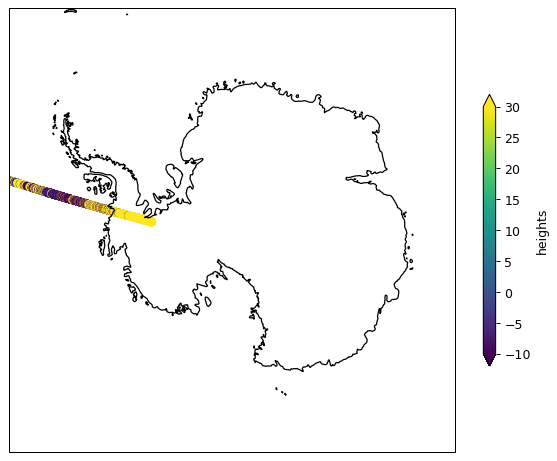

In [5]:
var= 'heights' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=-10
vmax=30
ticks=np.arange(-20,100,5)

# cartopy - need to make figure and set projection first before adding data
plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, -60, -90], ccrs.PlateCarree())
plt.scatter(df03['lons'][::1000], df03['lats'][::1000],c=df03[var][::1000], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

## Zoom in on a bounding box of interest

In [6]:
## create bounding box of interest:
lonmin,lonmax,latmin,latmax= [-90,-30,-65.1,-65]

bbox=(df03['lons']>lonmin)&(df03['lons']<lonmax)&(df03['lats']>latmin)&(df03['lats']<latmax)
df_cut=df03[bbox]

## converting GPS time to UTC time
epoch=is2_f['/ancillary_data/atlas_sdp_gps_epoch'][0]
df_cut['time']=Time(epoch+df_cut['dt'],format='gps').utc.datetime

## calculate along track distance relative to the beginning of the cut segment
# Subtract all along track x-values from first segment
df_cut['AT_dist']=df_cut.x-df_cut.x.values[0]

df_cut.head()

,lats,lons,x,y,heights,dt,conf,time,AT_dist
1215903,-65.000000,-79.431310,27317430.0,3392.105469,-0.577764,5.086854e+07,1,2019-08-12 18:09:03.613397,0.0
1215904,-65.000001,-79.431309,27317430.0,3392.146729,-5.976362,5.086854e+07,4,2019-08-12 18:09:03.613397,0.0
1215905,-65.000001,-79.431309,27317430.0,3392.154785,-7.006761,5.086854e+07,3,2019-08-12 18:09:03.613397,0.0
1215906,-65.000001,-79.431309,27317430.0,3392.149902,-6.384131,5.086854e+07,4,2019-08-12 18:09:03.613397,0.0
1215907,-65.000001,-79.431309,27317430.0,3392.146240,-5.892985,5.086854e+07,4,2019-08-12 18:09:03.613397,0.0


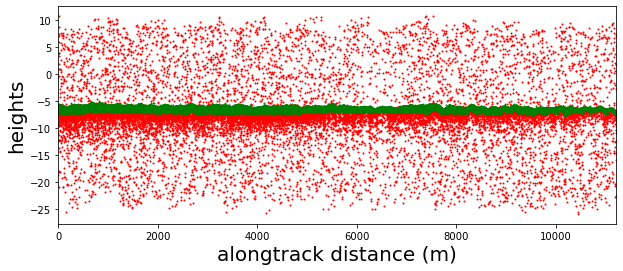

In [7]:
plt.subplots(1,1,figsize=(10,4))
plt.scatter(df_cut.AT_dist.values[df_cut.conf<3],df_cut.heights.values[df_cut.conf<3],c='r',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf>2],df_cut.heights.values[df_cut.conf>2],c='g',s=1)
plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.ylabel('heights',fontsize=20)
# plt.ylim(15,25);
plt.xlim(df_cut.AT_dist.values[0],df_cut.AT_dist.values[-1]);